In [1]:
from _collections_abc import Iterable
from functools import cached_property
import numpy as np
from matplotlib import pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical

# Implementation

In [2]:
class DenseLayer:
    def __init__(self,
                 n_in: int,
                 n_neu: int,
                 activation_function: str):
        self.activ_name = activation_function
        self.n_in = n_in
        self.n_out = n_neu
        self.weights = 2*np.random.random((n_neu, n_in+1))-1

    @cached_property
    def activ_func(self):
        activ_func_dict = {'sigmoid': lambda x: np.exp(x) / (1 + np.exp(x)),
                           'exponential': lambda x: np.exp(x),
                           'relu': lambda x: max((x,0)),
                           'softmax': lambda x: np.asarray([np.exp(i) / sum(np.exp(x)) for i in x])}
        func = activ_func_dict.get(self.activ_name)
        if not self.activ_name=='softmax':
            func = np.vectorize(func)
        return func
    
    @cached_property
    def d_activ_func(self):
        activ_func_dict = {'sigmoid': lambda x: np.exp(x) / (1 + np.exp(x))**2,
                           'exponential': lambda x: np.exp(x),
                           'relu': lambda x: (x>0)*1}
        func = activ_func_dict.get(self.activ_name)
        if not self.activ_name=='softmax':
            func = np.vectorize(func)
        return func
    
    def init_weights(self):
        if self.activ_name == 'relu':
            w = np.random.normal(0, 2/(self.n_in+self.n_out), size=(self.n_out, self.n_in))
        else:
            w = np.sqrt(6)*(2*np.random.random((self.n_out, self.n_in))-1)/np.sqrt(self.n_out+self.n_in)
        self.weights = np.c_[np.zeros(self.n_out), w]

    def forward_prop(self, input):
        self.input = np.vstack((1, input))
        self.out =  self.weights @ self.input
        return self.activ_func(self.out)
    
    def back_prop(self, output, dlda,  learning_rate: float):
        self.delta = dlda if self.activ_name=='softmax' else dlda * self.d_activ_func(output)
        self.result =  self.delta * self.input.reshape(1,-1)
        res = self.weights.T @ self.delta
        self.weights -= learning_rate * self.result
        return res

class NeuralNetwork:
    def __init__(self, loss_function='mse'): 
        self.layers = []
        self.loss_name = loss_function
    
    def add_layer(self,
                  n_in,
                  n_neu: int,
                  activation_function: str):
        '''
        Add layer to the model

        @n_in: (int) number of input neurons for this layer
        @n_neu: (int) number of output neurons for this layer
        @activation_function: (str) name of the activation function
        '''
        self.layers.append(DenseLayer(n_in, n_neu, activation_function))

    @cached_property
    def loss_func(self):
        loss_func_dict = {'mse': lambda x: np.mean((x[0]-x[1])**2), #x[0]-true label
                          'categorical_crossentropy': lambda x: -sum(x[0]*np.log(x[1]))}
        return loss_func_dict.get(self.loss_name)
    
    @cached_property
    def d_loss_func(self):
        loss_func_dict = {'mse': lambda x: 2*(x[1]-x[0])/x[0].size, #x[0]-true label
                          'categorical_crossentropy': lambda x: sum(x[0])*x[1]-x[0]}
        return loss_func_dict.get(self.loss_name)

    def fit(self, train_features: np.array, train_targets: np.array, epochs: int, learning_rate: float, val: Iterable[np.array] =None):
        '''
        Fit model to the given data

        @train_features: (np.array) array to fit the model to
        @train_targets: (np.array) array to verify the fit
        @epochs: (int) number of epochs for a model to be trained for
        @learning_rate: (float) number defining learning rate
        @val: (Iterable[np.array]) validation set in the form (validation_features, validation_targets),
                                    - model doesn't learn based on this [parameter], 
                                    default None (meaning the feature is not used)
        '''

        self.loss = []
        self.acc = []
        train_features = train_features.copy()
        train_targets = train_targets.copy()
        if val:
            self.val_loss = []
            self.val_acc = []
        for i in range(epochs):
            loss=0
            order = np.arange(train_features.shape[0])
            np.random.shuffle(order)
            train_features = train_features[order,:]
            train_targets = train_targets[order,:]
            for j in range(train_features.shape[0]):
                train = train_features[j,:].reshape(train_features[j,:].size,1)
                layer_out = train
                for layer in self.layers:
                    layer_out = layer.forward_prop(layer_out)
                targets = train_targets[j,:].reshape(train_targets[j,:].size,1)
                loss += self.loss_func((targets,layer_out))

                dlda = self.d_loss_func((targets,layer_out))
                for layer in self.layers[::-1]:
                    dlda = layer.back_prop(layer.out, dlda, learning_rate)[1:]
            self.set_learning_state(train_features, train_targets, val, epoch=i)
    
    def set_learning_state(self, x_train, y_train, val, epoch):
        self.predict(x_train, y_train)
        self.loss.append(self.test_loss)
        self.acc.append(self.test_acc)
        print(f'epoch: {epoch+1}, loss: {self.loss[-1]}, acc: {self.acc[-1]}')
        if val:
            self.predict(val[0], val[1])
            self.val_loss.append(self.test_loss)
            self.val_acc.append(self.test_acc)
            print(f'val_loss: {self.val_loss[-1]}, val_acc: {self.val_acc[-1]}')
            

    def predict(self, test_features: np.array, test_targets: np.array):
        '''
        Calculate loss and accuracy for prediction based on given test data

        @test_features: (np.array) array to use the model on
        @test_targets: (np.array) array with true values to check loss and accuracy
        '''
        test_acc = []
        test = test_features.copy()
        self.test_loss = 0
        for j in range(test.shape[0]):
            layer_out = test[j,:].reshape(test[j,:].size, 1)
            for layer in self.layers:
                layer_out = layer.forward_prop(layer_out)
            target = test_targets[j,:].reshape(test_targets[j,:].size,1)
            test_acc.append(np.argmax(target)==np.argmax(layer_out))
            self.test_loss += self.loss_func((target,layer_out))
        self.test_acc = np.mean(test_acc)
        self.test_loss /= test.shape[0]

def create_neu_network(neu_list: Iterable[int], activ_func_list: Iterable[str], loss_func: str = 'mse'):
    '''
    Create NeuralNetwork object from given parameters:

    @neu_list: (Iterable[int]) collection of neuron numbers in the order of layers
    @activ_func_list: (Iterable[str]) collection of activation functions in the order of layers
    @loss: (str) name of the loss function, default 'mse'

    return NeuralNetwork object with specified layers
    '''
    if len(neu_list)-1 != len(activ_func_list):
        raise ValueError(f'Incompatible list lengths: neu_list ({len(neu_list)}) and activ_func_list ({len(activ_func_list)})')
    neu_net = NeuralNetwork(loss_function=loss_func)
    for i in range(len(neu_list)-1):
        neu_net.add_layer(neu_list[i], neu_list[i+1], activ_func_list[i])
    return neu_net


# Data preparation

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))#[:1000,]
train_images = (train_images.astype('float32') / 255)
test_images = test_images.reshape((10000, 28 * 28))#[:1000,]
test_images = (test_images.astype('float32') / 255)


In [4]:
train_images.shape

(60000, 784)

In [5]:
train_labels = to_categorical(train_labels)#[:1000,]
test_labels = to_categorical(test_labels)#[:1000,]

# Models

## First model

In [6]:
first_network = NeuralNetwork('categorical_crossentropy')
first_network.add_layer(28*28, 128,'relu')
first_network.add_layer(128, 10,'softmax')

In [7]:
first_network.fit(train_images, train_labels, epochs=10, learning_rate=.01, val=(test_images, test_labels))

epoch: 1, loss: [0.24670489], acc: 0.93375
val_loss: [0.30594312], val_acc: 0.9248
epoch: 2, loss: [0.17036545], acc: 0.9509
val_loss: [0.2322437], val_acc: 0.9365
epoch: 3, loss: [0.12475981], acc: 0.9642
val_loss: [0.19848513], val_acc: 0.9504
epoch: 4, loss: [0.11239936], acc: 0.9669166666666666
val_loss: [0.19359188], val_acc: 0.9526
epoch: 5, loss: [0.09000576], acc: 0.97185
val_loss: [0.19586579], val_acc: 0.956
epoch: 6, loss: [0.07119219], acc: 0.9776333333333334
val_loss: [0.17295041], val_acc: 0.9615
epoch: 7, loss: [0.05672077], acc: 0.98165
val_loss: [0.1774149], val_acc: 0.9592
epoch: 8, loss: [0.04583955], acc: 0.9853
val_loss: [0.16069772], val_acc: 0.9642
epoch: 9, loss: [0.04426045], acc: 0.9853
val_loss: [0.18259554], val_acc: 0.9615
epoch: 10, loss: [0.03213756], acc: 0.9896833333333334
val_loss: [0.18611261], val_acc: 0.9661


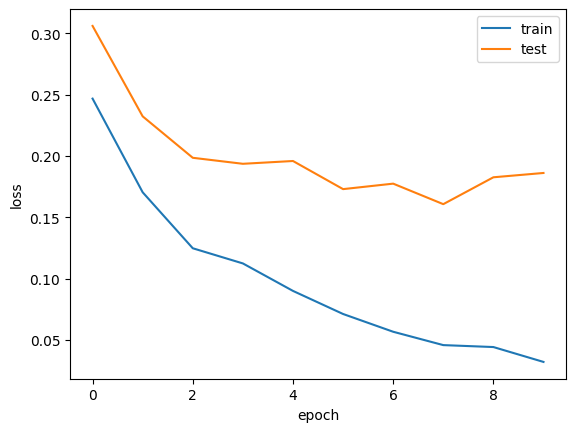

In [8]:
plt.plot(first_network.loss, label='train')
plt.plot(first_network.val_loss, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

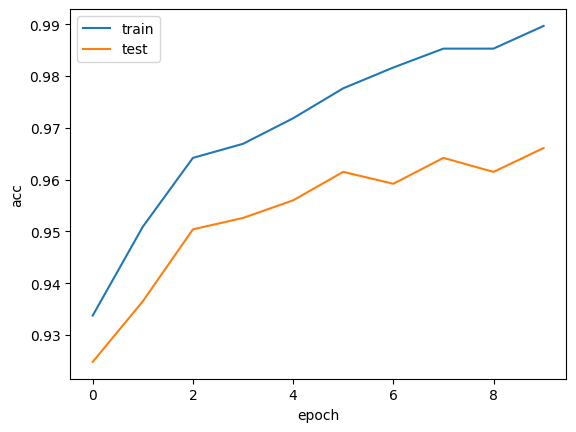

In [9]:
plt.plot(first_network.acc, label='train')
plt.plot(first_network.val_acc, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

In [10]:
first_network.predict(test_images, test_labels)
first_network.test_acc

0.9661

In [11]:
first_network.test_loss

array([0.18611261])

## Second model

In [12]:
second_network = NeuralNetwork('categorical_crossentropy')
second_network.add_layer(28*28, 128,'relu')
second_network.add_layer(128, 64,'sigmoid')
second_network.add_layer(64, 10,'softmax')

In [13]:
second_network.fit(train_images, train_labels, epochs=10, learning_rate=.01, val=(test_images, test_labels))


epoch: 1, loss: [0.29112734], acc: 0.9128333333333334
val_loss: [0.29648323], val_acc: 0.9122
epoch: 2, loss: [0.23000233], acc: 0.9306
val_loss: [0.2551226], val_acc: 0.9264
epoch: 3, loss: [0.18816341], acc: 0.9430833333333334
val_loss: [0.21288605], val_acc: 0.9371
epoch: 4, loss: [0.16750792], acc: 0.9483666666666667
val_loss: [0.20028606], val_acc: 0.9414
epoch: 5, loss: [0.14137926], acc: 0.9568166666666666
val_loss: [0.17587138], val_acc: 0.945
epoch: 6, loss: [0.13142009], acc: 0.9583833333333334
val_loss: [0.1672739], val_acc: 0.9505
epoch: 7, loss: [0.1187308], acc: 0.9637833333333333
val_loss: [0.15836412], val_acc: 0.9542
epoch: 8, loss: [0.10513568], acc: 0.9674833333333334
val_loss: [0.15570965], val_acc: 0.9559
epoch: 9, loss: [0.09887358], acc: 0.9695666666666667
val_loss: [0.14993188], val_acc: 0.9566
epoch: 10, loss: [0.0896463], acc: 0.9717666666666667
val_loss: [0.14120843], val_acc: 0.9588


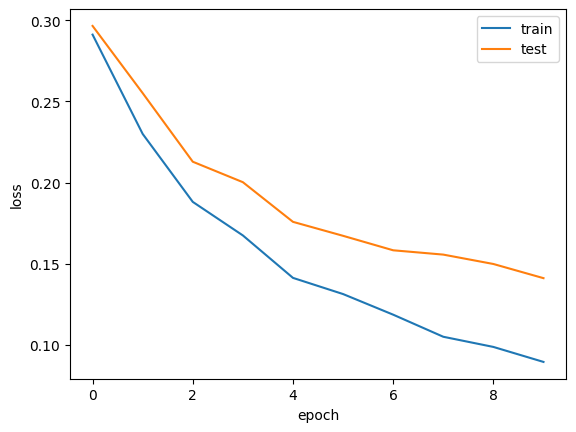

In [14]:
plt.plot(second_network.loss, label='train')
plt.plot(second_network.val_loss, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

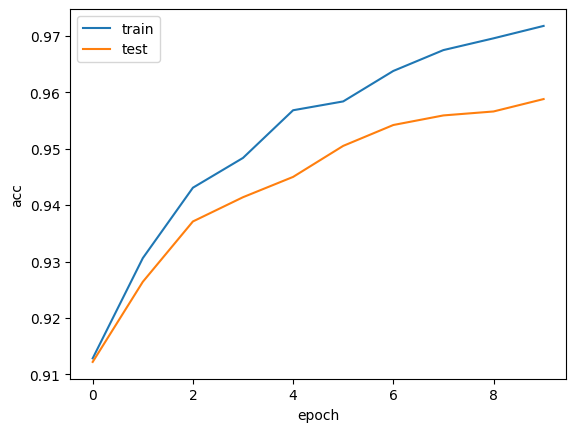

In [15]:
plt.plot(second_network.acc, label='train')
plt.plot(second_network.val_acc, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

## Third model

In [16]:
third_network = NeuralNetwork('mse')
third_network.add_layer(28*28, 128,'relu')
third_network.add_layer(128, 64,'sigmoid')
third_network.add_layer(64, 10,'softmax')

In [17]:
third_network.fit(train_images, train_labels, epochs=10, learning_rate=.01, val=(test_images, test_labels))


epoch: 1, loss: 0.02167104940807539, acc: 0.8525333333333334
val_loss: 0.021497034984162982, val_acc: 0.8535
epoch: 2, loss: 0.016277018943318074, acc: 0.8902333333333333
val_loss: 0.01668137035392154, val_acc: 0.8869
epoch: 3, loss: 0.013521194915324612, acc: 0.9101
val_loss: 0.01435235208333204, val_acc: 0.9056
epoch: 4, loss: 0.012098861714848908, acc: 0.91925
val_loss: 0.013347308231055652, val_acc: 0.9103
epoch: 5, loss: 0.01083243855180949, acc: 0.9277833333333333
val_loss: 0.012223122868156869, val_acc: 0.9183
epoch: 6, loss: 0.009871347123001592, acc: 0.9351333333333334
val_loss: 0.01151238050105057, val_acc: 0.9234
epoch: 7, loss: 0.009248069097197035, acc: 0.9390833333333334
val_loss: 0.011177261296950961, val_acc: 0.926
epoch: 8, loss: 0.00830989026930065, acc: 0.94555
val_loss: 0.010477716397051655, val_acc: 0.9315
epoch: 9, loss: 0.0078020777370385085, acc: 0.9493333333333334
val_loss: 0.010061434992271412, val_acc: 0.9335
epoch: 10, loss: 0.007223041301322282, acc: 0.9537

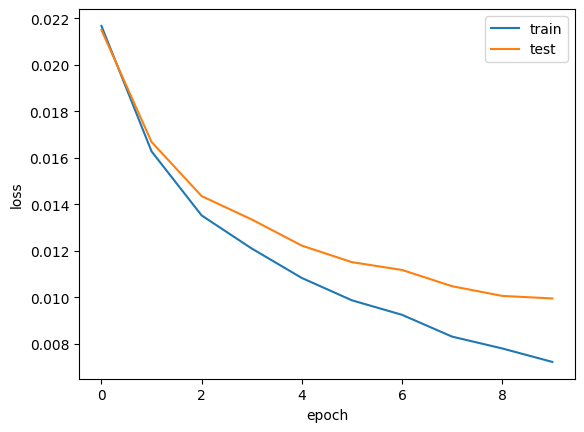

In [18]:
plt.plot(third_network.loss, label='train')
plt.plot(third_network.val_loss, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

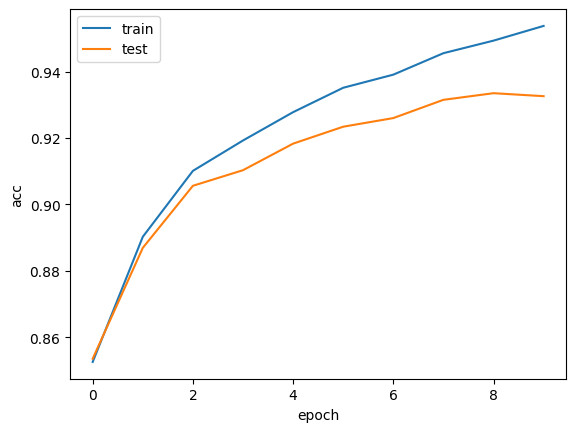

In [19]:
plt.plot(third_network.acc, label='train')
plt.plot(third_network.val_acc, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

## Fourth model

In [20]:
fourth_network = create_neu_network(neu_list = [28*28, 128, 64, 10], 
                                        activ_func_list=['relu', 'sigmoid', 'softmax'], 
                                        loss_func='categorical_crossentropy')
fourth_network.fit(train_images, train_labels, epochs=10, learning_rate=.01, val=(test_images, test_labels))

epoch: 1, loss: [0.28862932], acc: 0.9130833333333334
val_loss: [0.29347997], val_acc: 0.912
epoch: 2, loss: [0.22782263], acc: 0.9306666666666666
val_loss: [0.24502689], val_acc: 0.9293
epoch: 3, loss: [0.17762595], acc: 0.9459166666666666
val_loss: [0.19803569], val_acc: 0.9418
epoch: 4, loss: [0.15541231], acc: 0.9525333333333333
val_loss: [0.18109206], val_acc: 0.9457
epoch: 5, loss: [0.13435788], acc: 0.9596833333333333
val_loss: [0.17160029], val_acc: 0.951
epoch: 6, loss: [0.12636056], acc: 0.9607333333333333
val_loss: [0.16079191], val_acc: 0.951
epoch: 7, loss: [0.10411624], acc: 0.9692
val_loss: [0.14466617], val_acc: 0.9568
epoch: 8, loss: [0.10170534], acc: 0.9683
val_loss: [0.1498687], val_acc: 0.9547
epoch: 9, loss: [0.09314806], acc: 0.9709666666666666
val_loss: [0.1446493], val_acc: 0.9563
epoch: 10, loss: [0.08298639], acc: 0.9749
val_loss: [0.14008202], val_acc: 0.9583


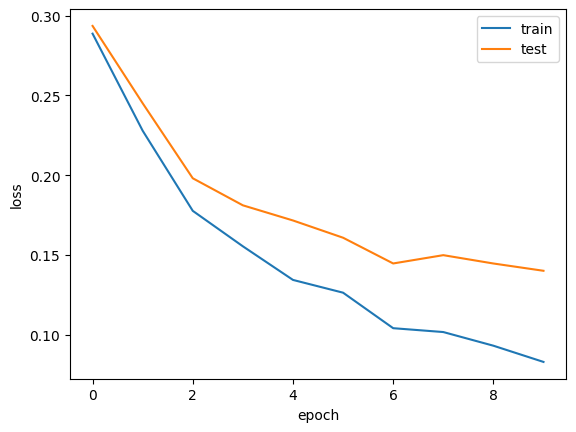

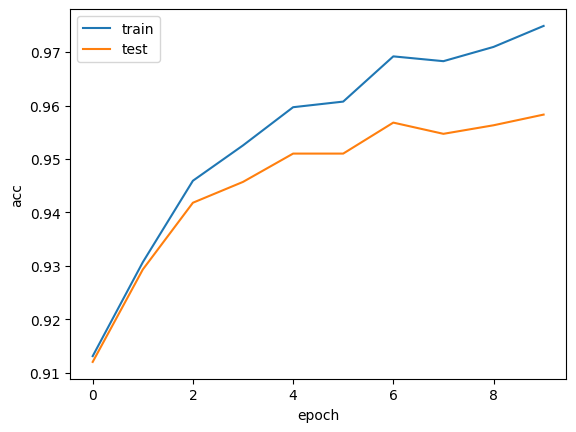

In [21]:
plt.plot(fourth_network.loss, label='train')
plt.plot(fourth_network.val_loss, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
plt.plot(fourth_network.acc, label='train')
plt.plot(fourth_network.val_acc, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()